## Things to do

1. Also check houses with sale prices of zero. 





In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats

Next I run the functions generated during this analsis. 

In [8]:
%run clean_data.py

In [9]:
ames = pd.read_csv('../datasets/train.csv')
ames, cat_label = clean_data(ames, version='mean')
ames = ames[ames['gr_liv_area']<4000]

> Two properties have a living area of more than 4000 sq. ft., and these two properties exert significant influence on the quality and accuracy of the model predictions. Hence, I will exclude them from the training set.

In [10]:
ames.isna().sum().sort_values(ascending=False).head(5)

Id              0
fireplace_qu    0
kitchen_qual    0
electrical      0
central_air     0
dtype: int64

> Sanity check: There is no missing data in the sample. The data has been correctly cleaned.

## Correlations:

### Correlation with the target

    In the following analysis, I identify the variables that exhibit the highest correlation with the target variable. These variables are likely to possess the highest predictive power.

In [11]:
corr_vars = ames.select_dtypes(include=['float64', 'int64']).iloc[:, 2:]

cond1 = ~corr_vars.columns.str.contains('_X_')
cond2 = ~corr_vars.columns.str.contains('squared')
cond3 = ~corr_vars.columns.str.contains('_sq')


corr_vars = ames[corr_vars.columns[cond1 & cond2 & cond3]]

In [12]:
highest_correlations = corr_vars.corr()['SalePrice'].abs().sort_values(ascending=False)[1:].head(10)
highest_correlations

total_area_sf     0.825387
gr_liv_area       0.719463
total_bsmt_sf     0.664541
garage_area       0.655458
garage_cars       0.648643
first_flr_sf      0.648252
total_bath        0.575008
age               0.572441
age_by_remodel    0.552226
mas_vnr_area      0.516378
Name: SalePrice, dtype: float64

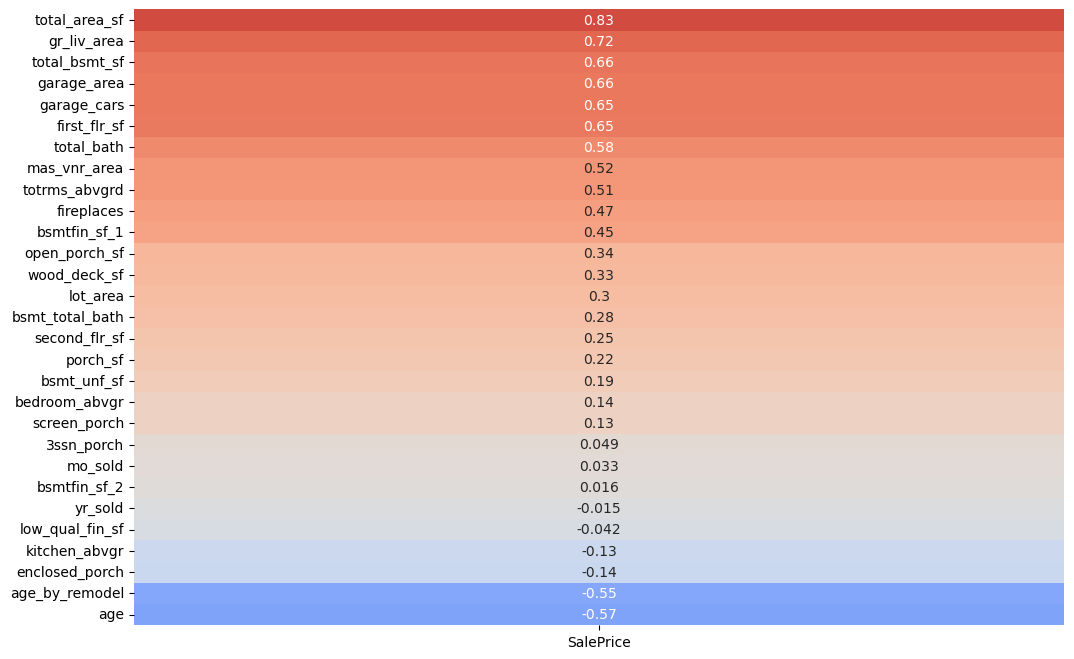

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=corr_vars.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)[1:], 
           vmin=-1,
           vmax=1, 
           cmap='coolwarm', 
           annot=True, 
           cbar=False);

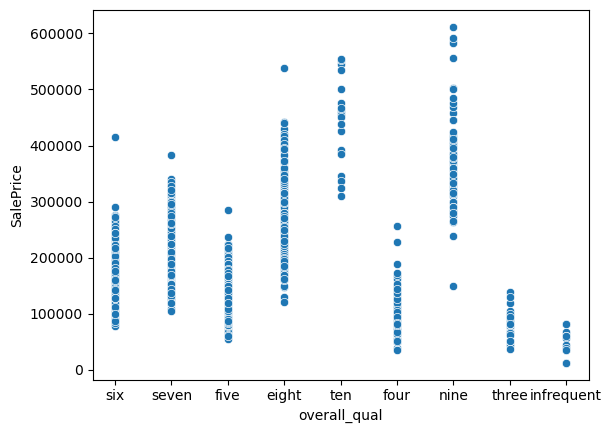

In [14]:
sns.scatterplot(data=ames, x='overall_qual', y='SalePrice');

Note that since `overall_qual` is a categorical variable, it is important to convert it to an object data type. In fact, using the object data type for `overall_qual` yields better model performance.

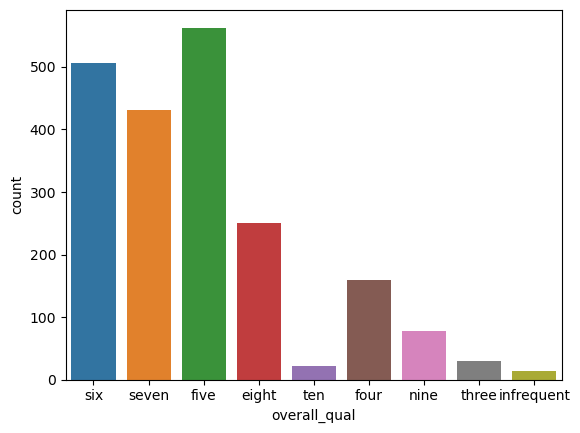

In [15]:
sns.countplot(data = ames, x = 'overall_qual');

> I believe the relationship between `overall_qual` and `SalePrice` exhibits a non-linear pattern. Since `overall_qual` is an ordinal variable, we have two options to incorporate it into the model. We can either create dummy variables to represent each level of `overall_qual`, or we can introduce the quadratic form of `overall_qual` as a feature in the model.

I learnt about customizing lmplots from this [link](https://stackoverflow.com/questions/53257382/what-do-scatter-kws-and-line-kws-do-in-seaborn-lmplot).

<Figure size 500x1200 with 0 Axes>

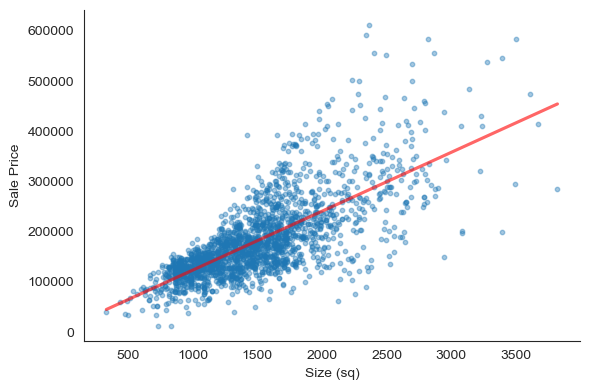

In [16]:
plt.figure(figsize=(5, 12))
sns.set_style('white')
sns.lmplot(data=ames, 
           x='gr_liv_area', 
           y='SalePrice', 
           ci=None,
           scatter_kws={'alpha': 0.4, 's': 10}, 
           line_kws={'color': 'red', 'alpha': 0.6},
           height=4,
           aspect = 1.5
           )
plt.ylabel('Sale Price')
plt.xlabel('Size (sq)')
plt.savefig('../images/size_vs_price.png', dpi=300);


<Figure size 1000x1000 with 0 Axes>

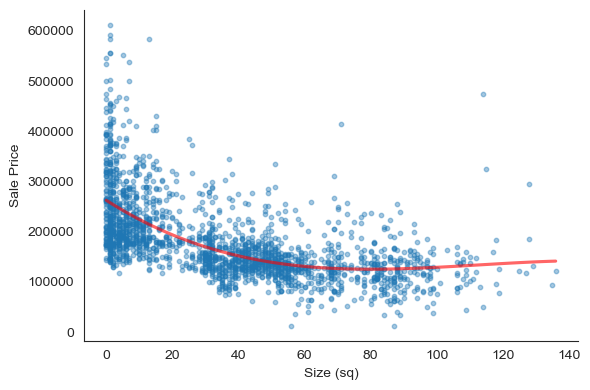

In [17]:
plt.figure(figsize=(10, 10))
sns.set_style('white')
sns.lmplot(data=ames, 
           x='age', 
           y='SalePrice', 
           order=3,
           ci=None,
           scatter_kws={'alpha': 0.4, 's': 10}, 
           line_kws={'color': 'red', 'alpha': 0.6},
           height=4,
           aspect = 1.5
           )
plt.ylabel('Sale Price')
plt.xlabel('Size (sq)')
plt.savefig('../images/age_vs_price.png', dpi=300);

> The relationship between `total_area_sf` and `SalePrice` also appears to exhibit a non-linear pattern.

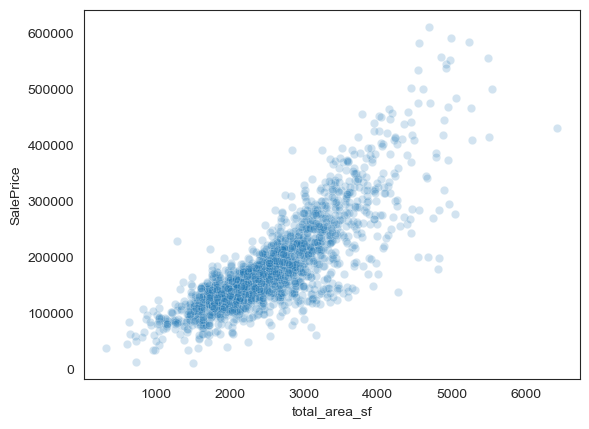

In [18]:
sns.scatterplot(data=ames, x='total_area_sf', y='SalePrice', alpha=0.2);

> The relationship between `gr_liv_area` and `SalePrice` also appears to exhibit a non-linear pattern.

### Correlations with SalePrice

In the code block below, I create a scatterplot to visualize the relationship between the top 31 features (excluding `overall_qual`, `gr_liv_area`, and `total_bsmt_sf`) and the target variable (`SalePrice`).

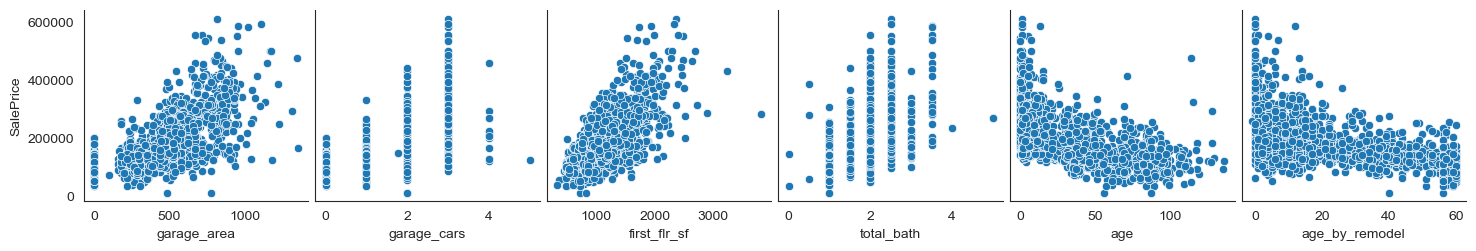

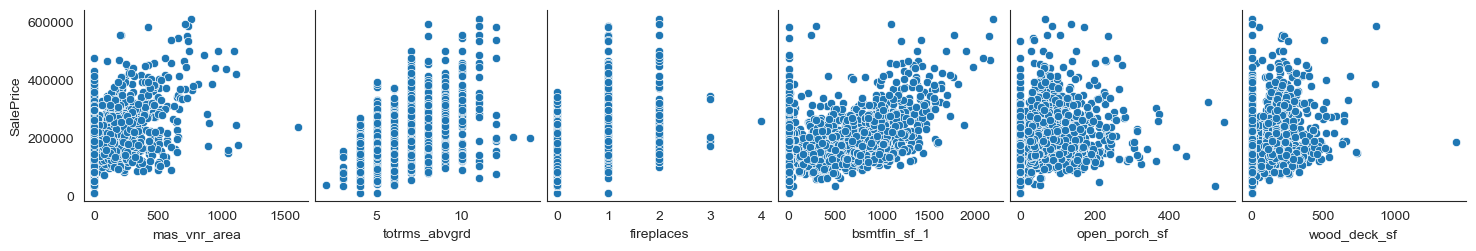

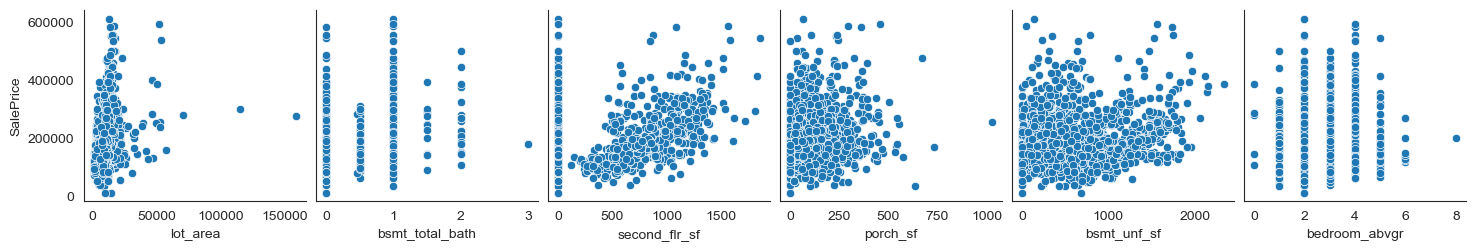

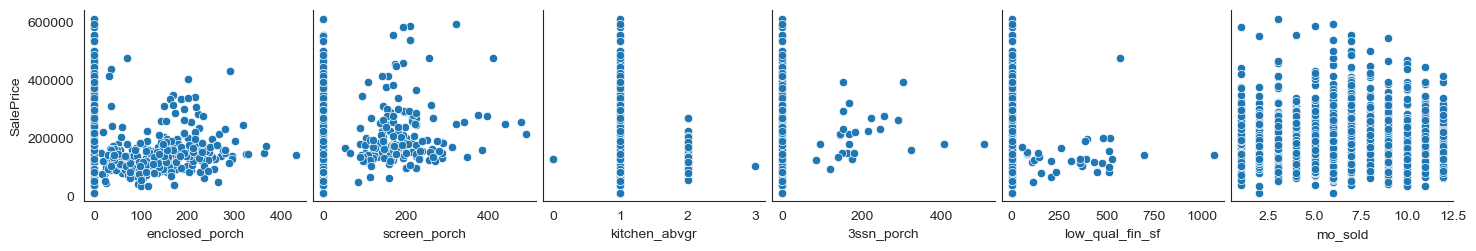

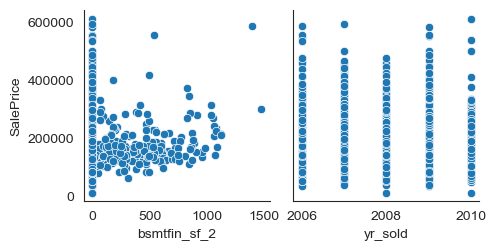

In [19]:
corr_with_sale = corr_vars.corr()['SalePrice'].abs().sort_values(ascending=False)[1:]
# plt.figure(figsize=(10,10))
for i in np.arange(3, corr_with_sale.shape[-1], 6):
    sns.pairplot(data=ames, y_vars='SalePrice', x_vars=corr_with_sale.index[i:i+6]);
    

> **Some interesting findings**: 
1. `Age` exhibits a non-linear relationship with `SalePrice`.
2. `SalePrice` appears to increase as `overall_cond` improves. Creating dummy variables for `overall_cond` could be beneficial.
3. When disregarding zero values in `bsmtfin_sf_1`, the relationship between `bsmtfin_sf_1` and `SalePrice` also appears to be non-linear.
4. `lot_area` exhibits extreme outliers.
5. `garage_area` and `second_flr_sf` show a clear positive relationship with `SalePrice`.
6. `totrms_abvgrd` appears to have a convex relationship with `SalePrice`.


### correlation among the numerical predictors.

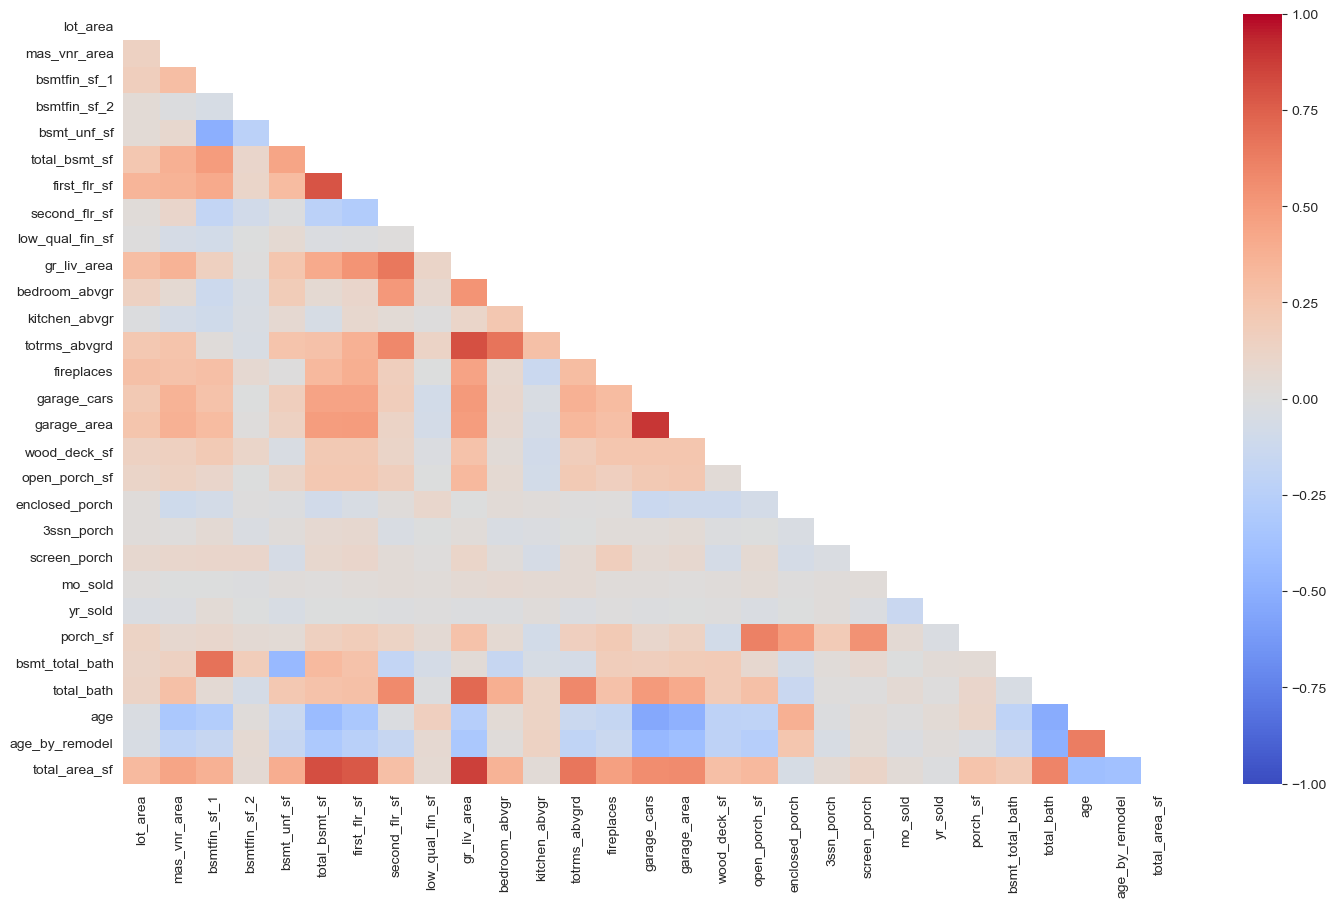

In [20]:
corr = corr_vars.corr(numeric_only=True).drop(columns=['SalePrice'], index=['SalePrice'])

mask = np.zeros_like(corr)

# mask = pd.concat([(corr[col].abs()<0.5)*1 for col in corr.columns], axis=1)

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html
# mask = mask.to_numpy()

mask[np.triu_indices_from(mask)] = True 

sns.set_style('white')
plt.figure(figsize=(17, 10))
sns.heatmap(corr, 
           cmap='coolwarm',
           vmin=-1, 
           vmax=1, 
           annot=False, 
           cbar=True, 
           fmt='.1g', 
           mask=mask);

It is very hard to focus on any relationship in this plot. In the following, I will locate only the ones with moderate to strong correaltion.

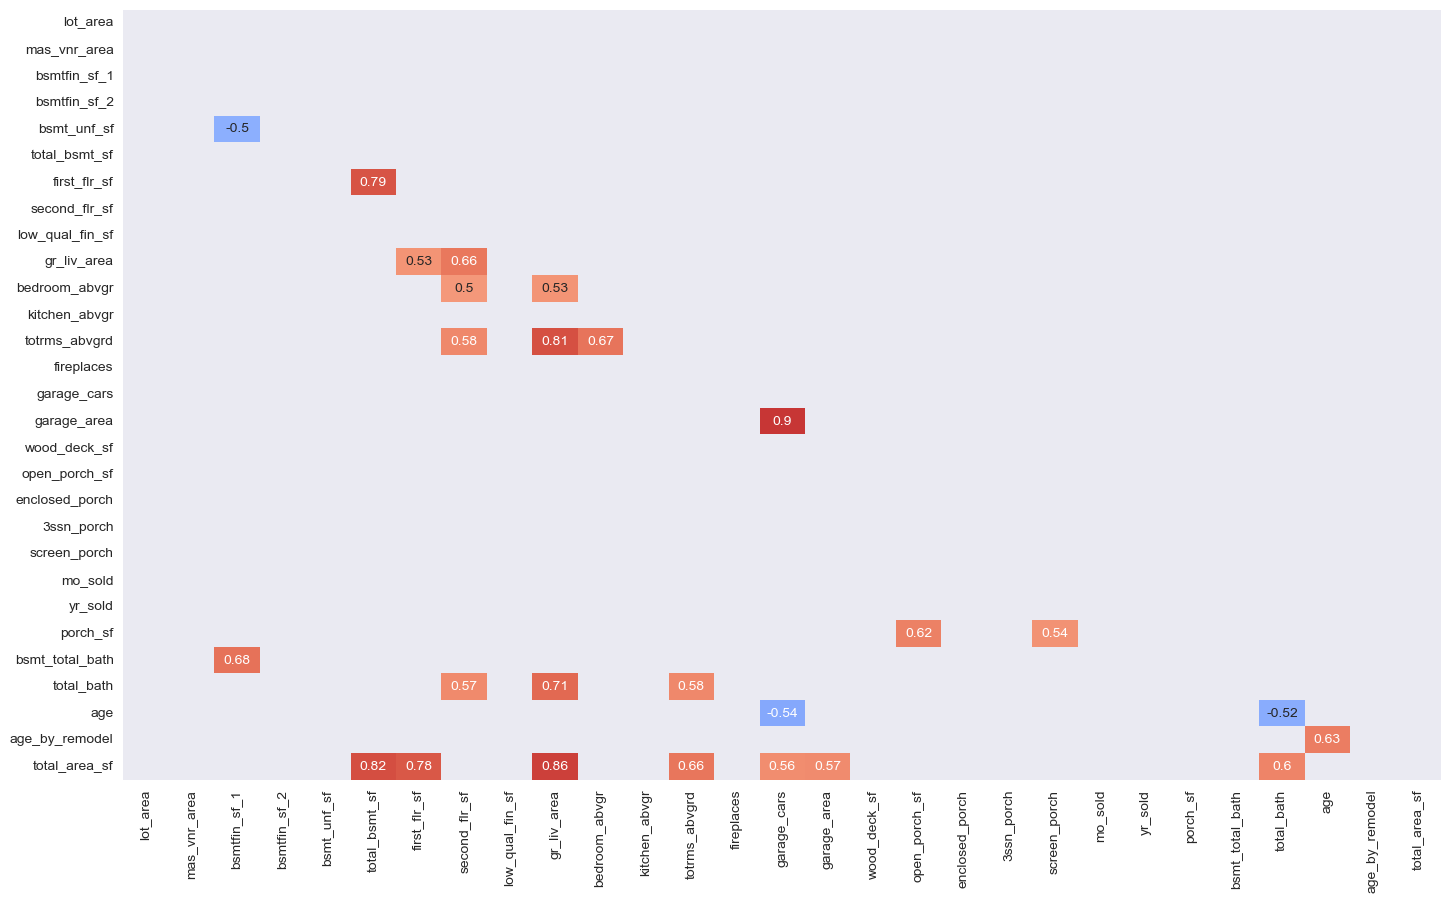

In [21]:
mask = np.zeros_like(corr)

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html
mask = pd.concat([(corr[col].abs()<0.5)*1 for col in corr.columns], axis=1).to_numpy()

mask[np.triu_indices_from(mask)] = True 

sns.set_style('dark')
plt.figure(figsize=(17, 10))
sns.heatmap(corr, 
           cmap='coolwarm',
           vmin=-1, 
           vmax=1, 
           annot=True, 
           cbar=False, 
           fmt='.2g', 
           mask=mask);

> **Interesting findings:**

1. There is a high correlation between `garage_area` and `garage_cars`.
1. There is a high correlation between `totms_abvgr` and `gr_liv_area`.
1. There is a high correlation between `first_floor_sf` and `total_bsmt_sf`.
1. `Total_bath` and `gr_liv_area` have a high positive correlation, as expected.
1. `Bsmt_total_bath` and `bsmtfin_sf_1` are highly correlated.
1. There are other strong correlations among the predictors that one should be careful about.

In [88]:
ames.describe().T.iloc[1:, 1:]

,mean,std,min,25%,50%,75%,max
lot_frontage,6.890738e+01,2.058224e+01,21.0,60.0,6.905520e+01,78.0,313.0
lot_area,1.002468e+04,6.608512e+03,1300.0,7500.0,9.405000e+03,11500.0,159000.0
mas_vnr_area,9.880737e+01,1.716345e+02,0.0,0.0,0.000000e+00,158.0,1600.0
bsmtfin_sf_1,4.380206e+02,4.397362e+02,0.0,0.0,3.680000e+02,733.0,2188.0
bsmtfin_sf_2,4.800584e+01,1.650344e+02,0.0,0.0,0.000000e+00,0.0,1474.0
bsmt_unf_sf,5.675255e+02,4.449109e+02,0.0,220.0,4.750000e+02,811.0,2336.0
total_bsmt_sf,1.053552e+03,4.261794e+02,0.0,793.0,9.940000e+02,1317.0,3206.0
first_flr_sf,1.160848e+03,3.790661e+02,334.0,879.0,1.092000e+03,1404.0,3820.0
second_flr_sf,3.291869e+02,4.255957e+02,0.0,0.0,0.000000e+00,691.0,1862.0
low_qual_fin_sf,5.518302e+00,5.109351e+01,0.0,0.0,0.000000e+00,0.0,1064.0


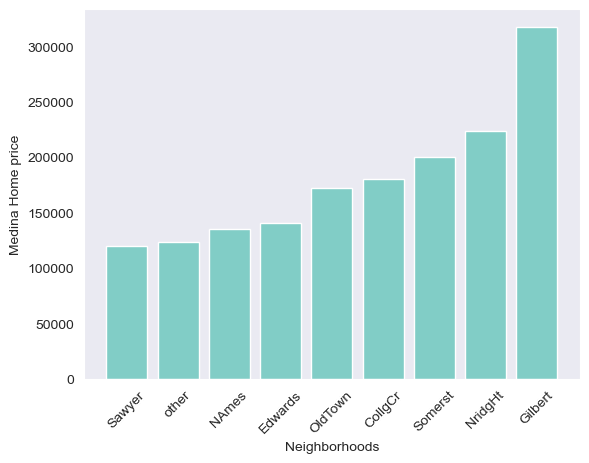

In [89]:
value_counts = ames['neighborhood'].value_counts()
low_freq_levels = value_counts[value_counts < 100].index
ames['neighborhood'] = np.where(ames['neighborhood'].isin(low_freq_levels), 'other', ames['neighborhood'])

plt.bar(ames['neighborhood'].unique(), height = ames.groupby('neighborhood')['SalePrice'].median().sort_values(), color ='#81cdc6')
plt.xticks(rotation = 45)
plt.xlabel('Neighborhoods')
plt.ylabel('Medina Home price');


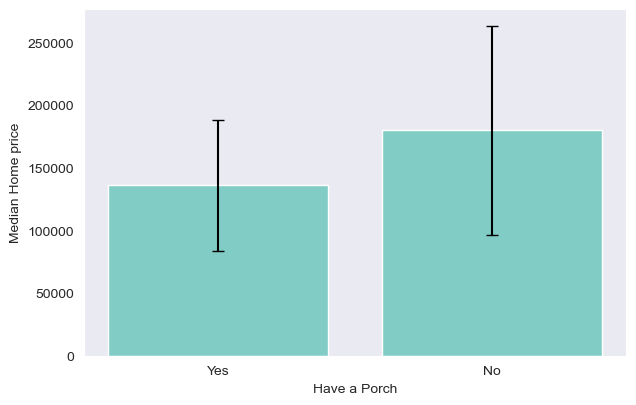

In [90]:
plt.figure(figsize=(7, 4.5))
plt.bar(ames['have_porch_sf'].unique(), height = ames.groupby('have_porch_sf')['SalePrice'].median(), color ='#81cdc6')
plt.errorbar(x=ames['have_porch_sf'].unique(), 
             y = ames.groupby('have_porch_sf')['SalePrice'].median(), 
             yerr=ames.groupby('have_porch_sf')['SalePrice'].std(), 
             fmt='none', 
             color='black', 
             capsize=4)


plt.xlabel('Have a Porch')
plt.ylabel('Median Home price')
plt.savefig('../images/porch.png', dpi=300);

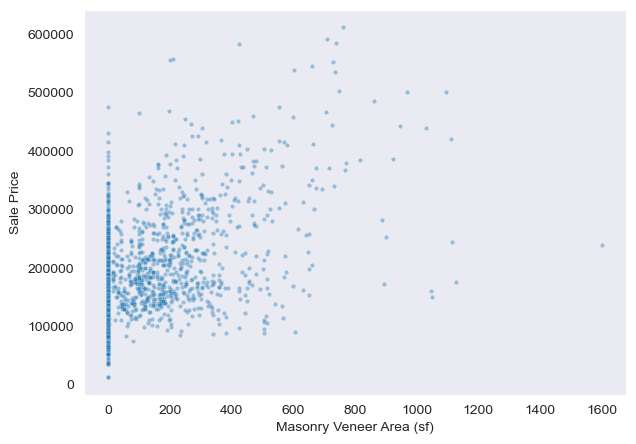

In [91]:
plt.figure(figsize=(7, 5))

sns.scatterplot(data=ames, x='mas_vnr_area', y='SalePrice', alpha=0.4, s=10);

plt.ylabel('Sale Price')
plt.xlabel('Masonry Veneer Area (sf)')
plt.savefig('../images/mas_vnr_vs_price.png', dpi=300);

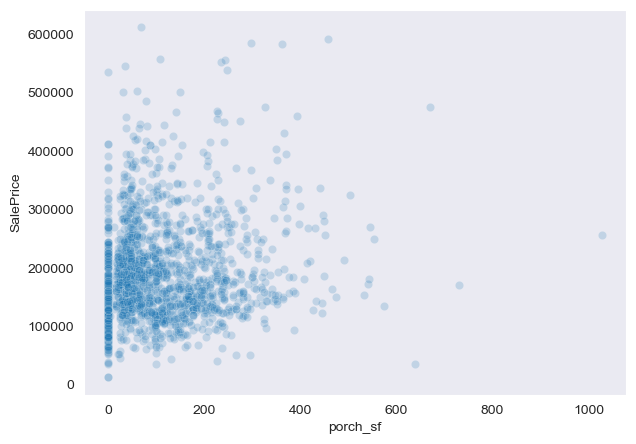

In [92]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=ames, x='porch_sf', y='SalePrice', alpha=0.2);



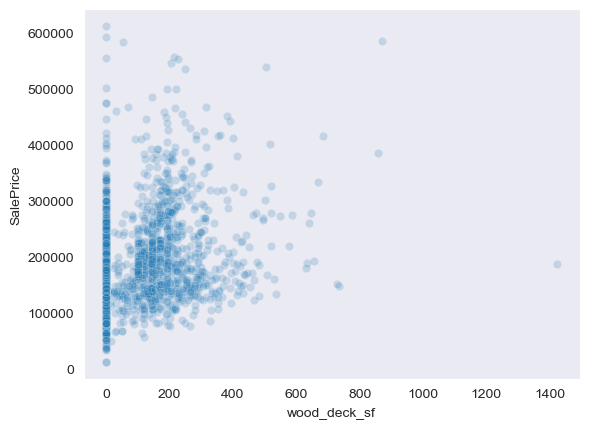

In [93]:
sns.scatterplot(data=ames, x='wood_deck_sf', y='SalePrice', alpha=0.2);

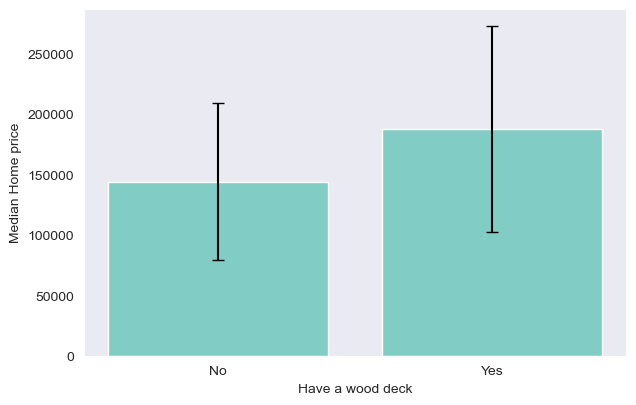

In [94]:
plt.figure(figsize=(7, 4.5))
plt.bar(ames['have_wood_deck_sf'].unique(), height = ames.groupby('have_wood_deck_sf')['SalePrice'].median(), color ='#81cdc6')
plt.errorbar(x=ames['have_wood_deck_sf'].unique(), 
             y = ames.groupby('have_wood_deck_sf')['SalePrice'].median(), 
             yerr=ames.groupby('have_wood_deck_sf')['SalePrice'].std(), 
             fmt='none', 
             color='black', 
             capsize=4)

plt.xlabel('Have a wood deck')
plt.ylabel('Median Home price')
plt.savefig('../images/wood_deck.png', dpi=300);